In [1]:
import stan
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json

# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
df = pd.read_csv('df_main.csv')
print(df.columns)
df.head()

Index(['year', 'Artist', 'from_country', 'to_country', 'points',
       'total_points', 'rank', 'from_code2', 'from_code3', 'to_code2',
       'to_code3', 'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'migration_v2p', 'population_p', 'prop_emigrants_v2p', 'migration_p2v',
       'population_v', 'prop_emigrants_p2v', 'migration_pop_year',
       'comps_without_win', 'has_border'],
      dtype='object')


,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42,False
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42,False
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42,False
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42,False
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42,False


In [3]:
def format_votes(x):
  if x == 12.:
    return 10
  elif x == 10.:
    return 9
  return int(x)
df['indexed_votes'] = df['points'].apply(format_votes) + 1
score_options = df['indexed_votes'].unique().tolist()
score_options.sort()
print(score_options)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [4]:
# Given gender is a categoric variable with 3 classes, encode as binary w.r.t default gender='group'
df['male'] = [1 if gender=='male' else 0 for gender in df['gender']]
df['female'] = [1 if gender=='female' else 0 for gender in df['gender']]

# Evaluate binary variables for boolean covariates to be used
df['Contains_English_bin'] = df['Contains_English'].apply(lambda x: 1 if x else 0)
df['Contains_Own_Language_bin'] = df['Contains_Own_Language'].apply(lambda x: 1 if x else 0)

In [6]:
with open('generated_objects/vptoi.json') as f:
    vptoi = f.read()
vptoi = json.loads(vptoi)
with open('generated_objects/itovp.json') as f:
    itovp = f.read()
itovp = json.loads(itovp)

df['vp'] = df.apply(lambda x: vptoi[f'{x["from_code2"]}-{x["to_code2"]}'], axis=1)
print(f"\ncheck index of BE-HR: {vptoi['BE-HR']}")
print(f"check index of BE-CY: {vptoi['BE-CY']}")
df[ ["from_code2","to_code2","vp"]].head()


check index of BE-HR: 993
check index of BE-CY: 474


,from_code2,to_code2,vp
0,BE,HR,993
1,BE,CY,474
2,BE,EE,661
3,BE,MK,1461
4,BE,FI,755


In [7]:
df['year'].unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2021, 2022])

In [71]:
# test/train split
# Reserve data from 2019-2022 for testing model on unseen data
print(f'full df shape: {df.shape}')
df_train = df.loc[ df['year'] <= 2018 ]
df_test = df.loc[ df['year'] > 2018 ]
print(f'train df shape: {df_train.shape}')
print(f'test df shape: {df_test.shape}')

full df shape: (21310, 33)
train df shape: (1106, 33)
test df shape: (3003, 33)


In [91]:
model = """
// overload add function for adding an int to an array of ints
functions {
  array[] int add(array[] int x, int y) {
      int x_size = size(x);
      array[x_size] int z;
      for (i in 1:x_size){
        z[i] = x[i] + y;
      }
      return z;
  }
}
data {
  int<lower=2> S;
  int<lower=0> N;   // total number of performances
  int<lower=1> B;   // number of performance dependent covariates
  int<lower=1> PHI; // number of voter/performer pair dependent covariates
  int<lower=1> VP;  // number of voter/performer combinations

  array[N] int<lower=1, upper=S> y;
  matrix[N,B] xbeta;       // performance dependent covariates
  matrix[VP,PHI] xphi;     // voter/performer pair dependent covariates
  array[N] int<lower=0,upper=VP-1> vp;  // voter/performer pair index

  int<lower=0> N_new; // number of predictions
  matrix[N_new,B] xbeta_new;
  array[N_new] int<lower=0,upper=VP-1> vp_new;

}
parameters {
  vector[B] beta;
  vector[PHI] phi;
  vector[VP] alpha;
  ordered[S-1] lambda;
  real gamma;
  real<lower=0> sigmaAlpha;
}
model {
  gamma ~ normal(0, 10000);
  beta ~ normal(0, 10000);
  lambda ~ normal(0, 3.2);
  sigmaAlpha ~ cauchy(0,1);

  alpha ~ normal( xphi * phi, sigmaAlpha );

  for (n in 1:N) {
    if (y[n] == 0) {
      1 ~ bernoulli_logit(gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta));
    } else {
      0 ~ bernoulli_logit(gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta));
      y[n] ~ ordered_logistic(gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta), lambda);
    }
  }
  
  // remembering that vp is 0-indexed and alpha is 1-indexed
  // y ~ ordered_logistic( gamma + alpha[ add(vp,1) ] + (xbeta * beta), lambda );

}
generated quantities {
  vector[N] y_hat;
  for (n in 1:N) {
    if (bernoulli_logit_rng(gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta)) == 0) {
      y_hat[n] = 0;
    } else {
      y_hat[n] = ordered_logistic_rng( gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta), lambda);
    }
  }

  // out of sample predictions (scores we expect to observe for new data)
  vector[N_new] y_pred;
  for (n in 1:N_new) {
    if (bernoulli_logit_rng(gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta)) == 0) {
      y_pred[n] = 0;
    } else {
      y_pred[n] = ordered_logistic_rng(gamma + alpha[ add(vp[n],1) ] + (xbeta[n] * beta), lambda);
    }
  }
}
"""

In [73]:
# build xbeta matrix
xbeta_train = df_train.loc[:,['Contains_English_bin','Contains_Own_Language_bin','male','female','comps_without_win']].values
print(xbeta_train.shape)
# minmax scaling of 'comps_since_last_win'
scaler = MinMaxScaler() 
xbeta_train_norm = scaler.fit_transform(xbeta_train)

xbeta_test = df_test.loc[:,['Contains_English_bin','Contains_Own_Language_bin','male','female','comps_without_win']].values
print(xbeta_test.shape)
# minmax scaling of 'comps_since_last_win'
xbeta_test_norm = scaler.transform(xbeta_test)

(1106, 5)
(3003, 5)


The xphi matrix has shape (num of v-p pairs, 2)
The two colums contain a binary measure of whether or not the voter shares a border with the performer, and a measure of the intensity of the migration from the voter to the performer. The latter is calculated as an average over time:

ave intensity = mean( num migrants from v to p / population of v )

In [74]:
df_border = pd.read_csv('final_border_data_long.csv')
df_border.head()

,Unnamed: 0,country_code_1,country_code_2,has_border
0,0,AT,AT,NaN
1,1,AT,BA,NaN
2,2,AT,BE,NaN
3,3,AT,CY,NaN
4,4,AT,DE,1.0


mean = 0.0 count: 13
mean = nan count: 473

Note that 21.75% of the v-p pairs get the substitute value for migration intensity because there was no migration information.


Text(0.5, 1.0, 'distribution of available non-zero migration data (used to infer missing data)')

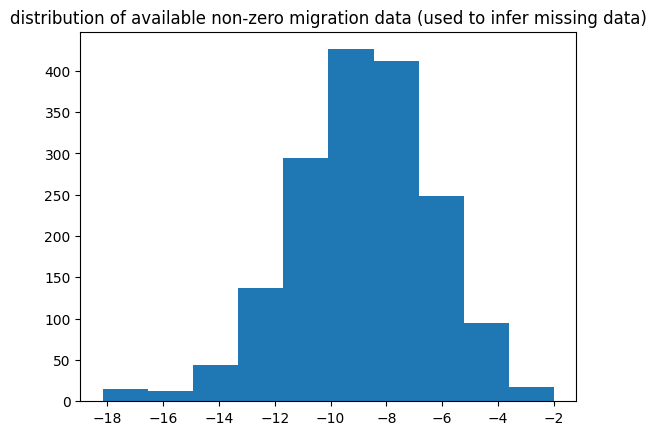

In [75]:
# build xphi matrix
xphi = np.zeros((len(vptoi), 2))
migration_means = []
zero_count = 0
nan_count = 0
for pair,idx in vptoi.items():
    v = pair[:2]
    p = pair[-2:]
    has_border = df_border.loc[ (df_border['country_code_1'] == v) & (df_border['country_code_2'] == p) ]['has_border'].item()
    xphi[idx][0] = 0.0 if math.isnan(has_border) else has_border

    migration_series = df.loc[ (df['from_code2'] == v) & (df['to_code2'] == p) ]['prop_emigrants_v2p']
    if migration_series.isnull().any():
        # if no migration data is available, use the plot below to infer the most appropriate substitute value
        # this should be a better alternative to assuming 0 migration
        xphi[idx][1] = math.exp(-9) - 2.6e-08/2
        nan_count += 1
    else:
        mean_migration = migration_series.mean()
        xphi[idx][1] = mean_migration

        # below lines for informational purpose
        if mean_migration == 0.0:
            zero_count +=1
        migration_means.append(mean_migration)

print(f'mean = 0.0 count: {zero_count}')
print(f'mean = nan count: {nan_count}')
print(f'\nNote that {round(100*nan_count/len(vptoi),2)}% of the v-p pairs get the substitute value for migration intensity because there was no migration information.')
plt.hist(np.log(np.array(migration_means) + 2.6e-08/2)) # translate by half of smallest non-zero value
plt.title('distribution of available non-zero migration data (used to infer missing data)')

    

smallest non-zero value: 2.6071052952733155e-08


Text(0.5, 1.0, 'normalised migration intensity values for 2175 v-p pairs')

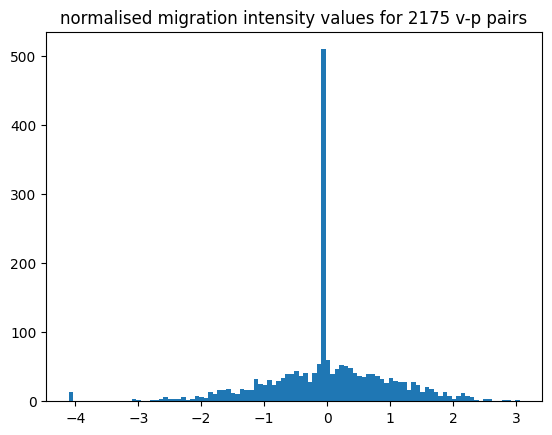

In [76]:
# standardise the migration intensity feature in xphi with a log transform and standardisation
mig_ints = xphi[:,1]
mig_ints_sort = np.sort(mig_ints)
print(f'smallest non-zero value: {mig_ints_sort[mig_ints_sort != 0][0]}')

mig_ints_log = np.log10(mig_ints + 2.6e-08/2)   # rule of thumb, half of smallest non-zero value
std_scaler = StandardScaler()
mig_ints_log_std = std_scaler.fit_transform(mig_ints_log.reshape(-1, 1))

# write scaler version of xphi
xphi_norm = xphi.copy()
xphi_norm[:,1] = mig_ints_log_std.reshape((2175,))

plt.hist(xphi_norm[:,1],bins=100)
plt.title(f'normalised migration intensity values for {len(vptoi)} v-p pairs')


In [92]:
data = {
    'S': 11,
    'N': df_train.shape[0],
    'B': xbeta_train_norm.shape[1],
    'PHI' : xphi_norm.shape[1],
    'VP' : xphi_norm.shape[0],
    'y': df_train['indexed_votes'].values,
    'xbeta': xbeta_train_norm,
    'xphi' : xphi_norm,
    'vp' : df_train['vp'].values,
    'N_new': df_test.shape[0],
    'xbeta_new': xbeta_test_norm,
    "vp_new" : df_test['vp'].values
}

In [93]:
posterior = stan.build(model, data=data)
fit = posterior.sample(num_chains=2, num_warmup=1000, num_samples=1000)

Building...

In file included from /Users/echapman/Library/Caches/httpstan/4.9.1/models/yxdl5hra/model_yxdl5hra.cpp:2:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/echapm

19 warnings generated.
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/stan_services.o) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_cvodes.a(cvodea.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_idas.a(idaa.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/Eurovision_TDS/.venv/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(s

In [94]:
az_fit = az.from_pystan(
    posterior=fit, 
    observed_data="y", 
    posterior_predictive="y_hat",
    predictions="y_pred", 
    posterior_model=posterior)

In [95]:
az_fit.to_json("model_output/model_3_voter_bias_vector_1000_samples_2_chains_1998-1999_incYpred.json")

'model_output/model_3_voter_bias_vector_1000_samples_2_chains_1998-1999_incYpred.json'

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n4'}>]], dtype=object)

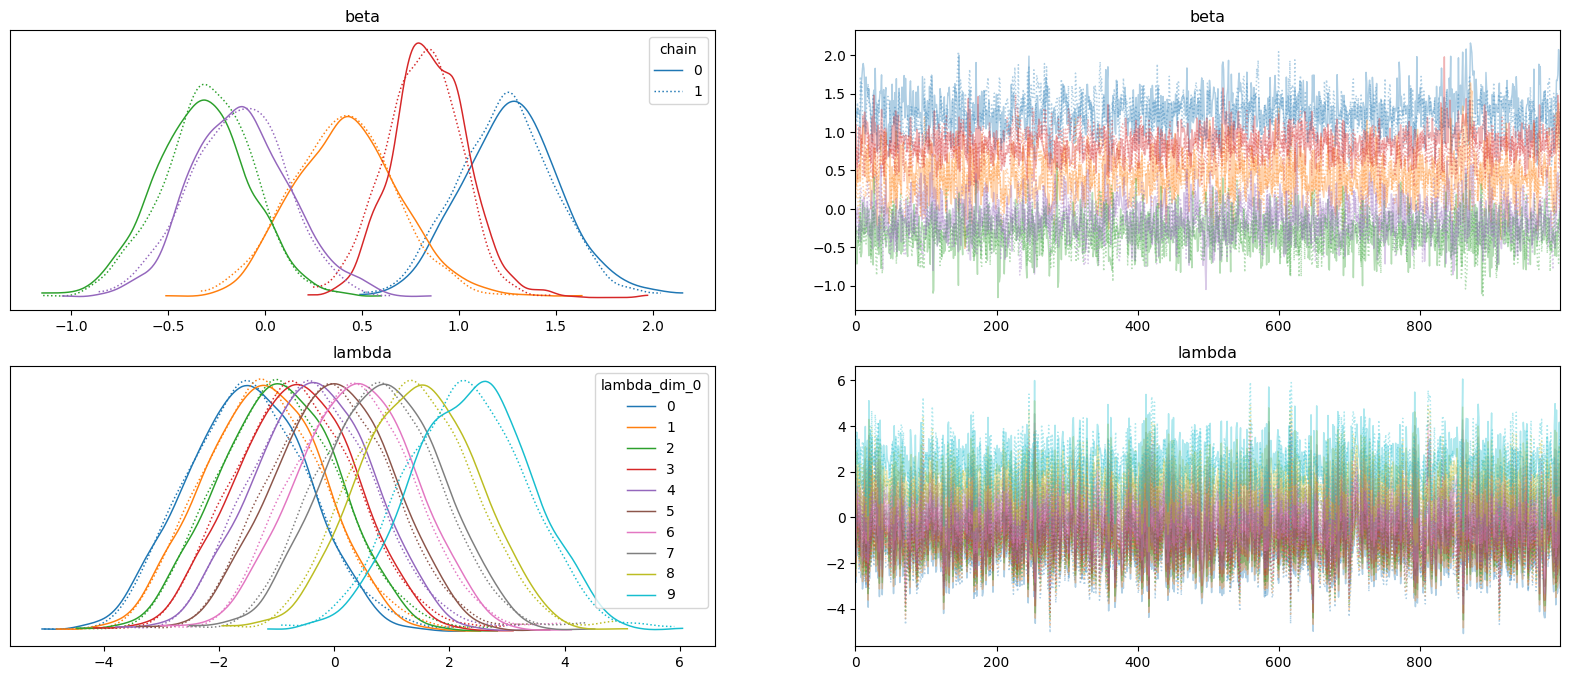

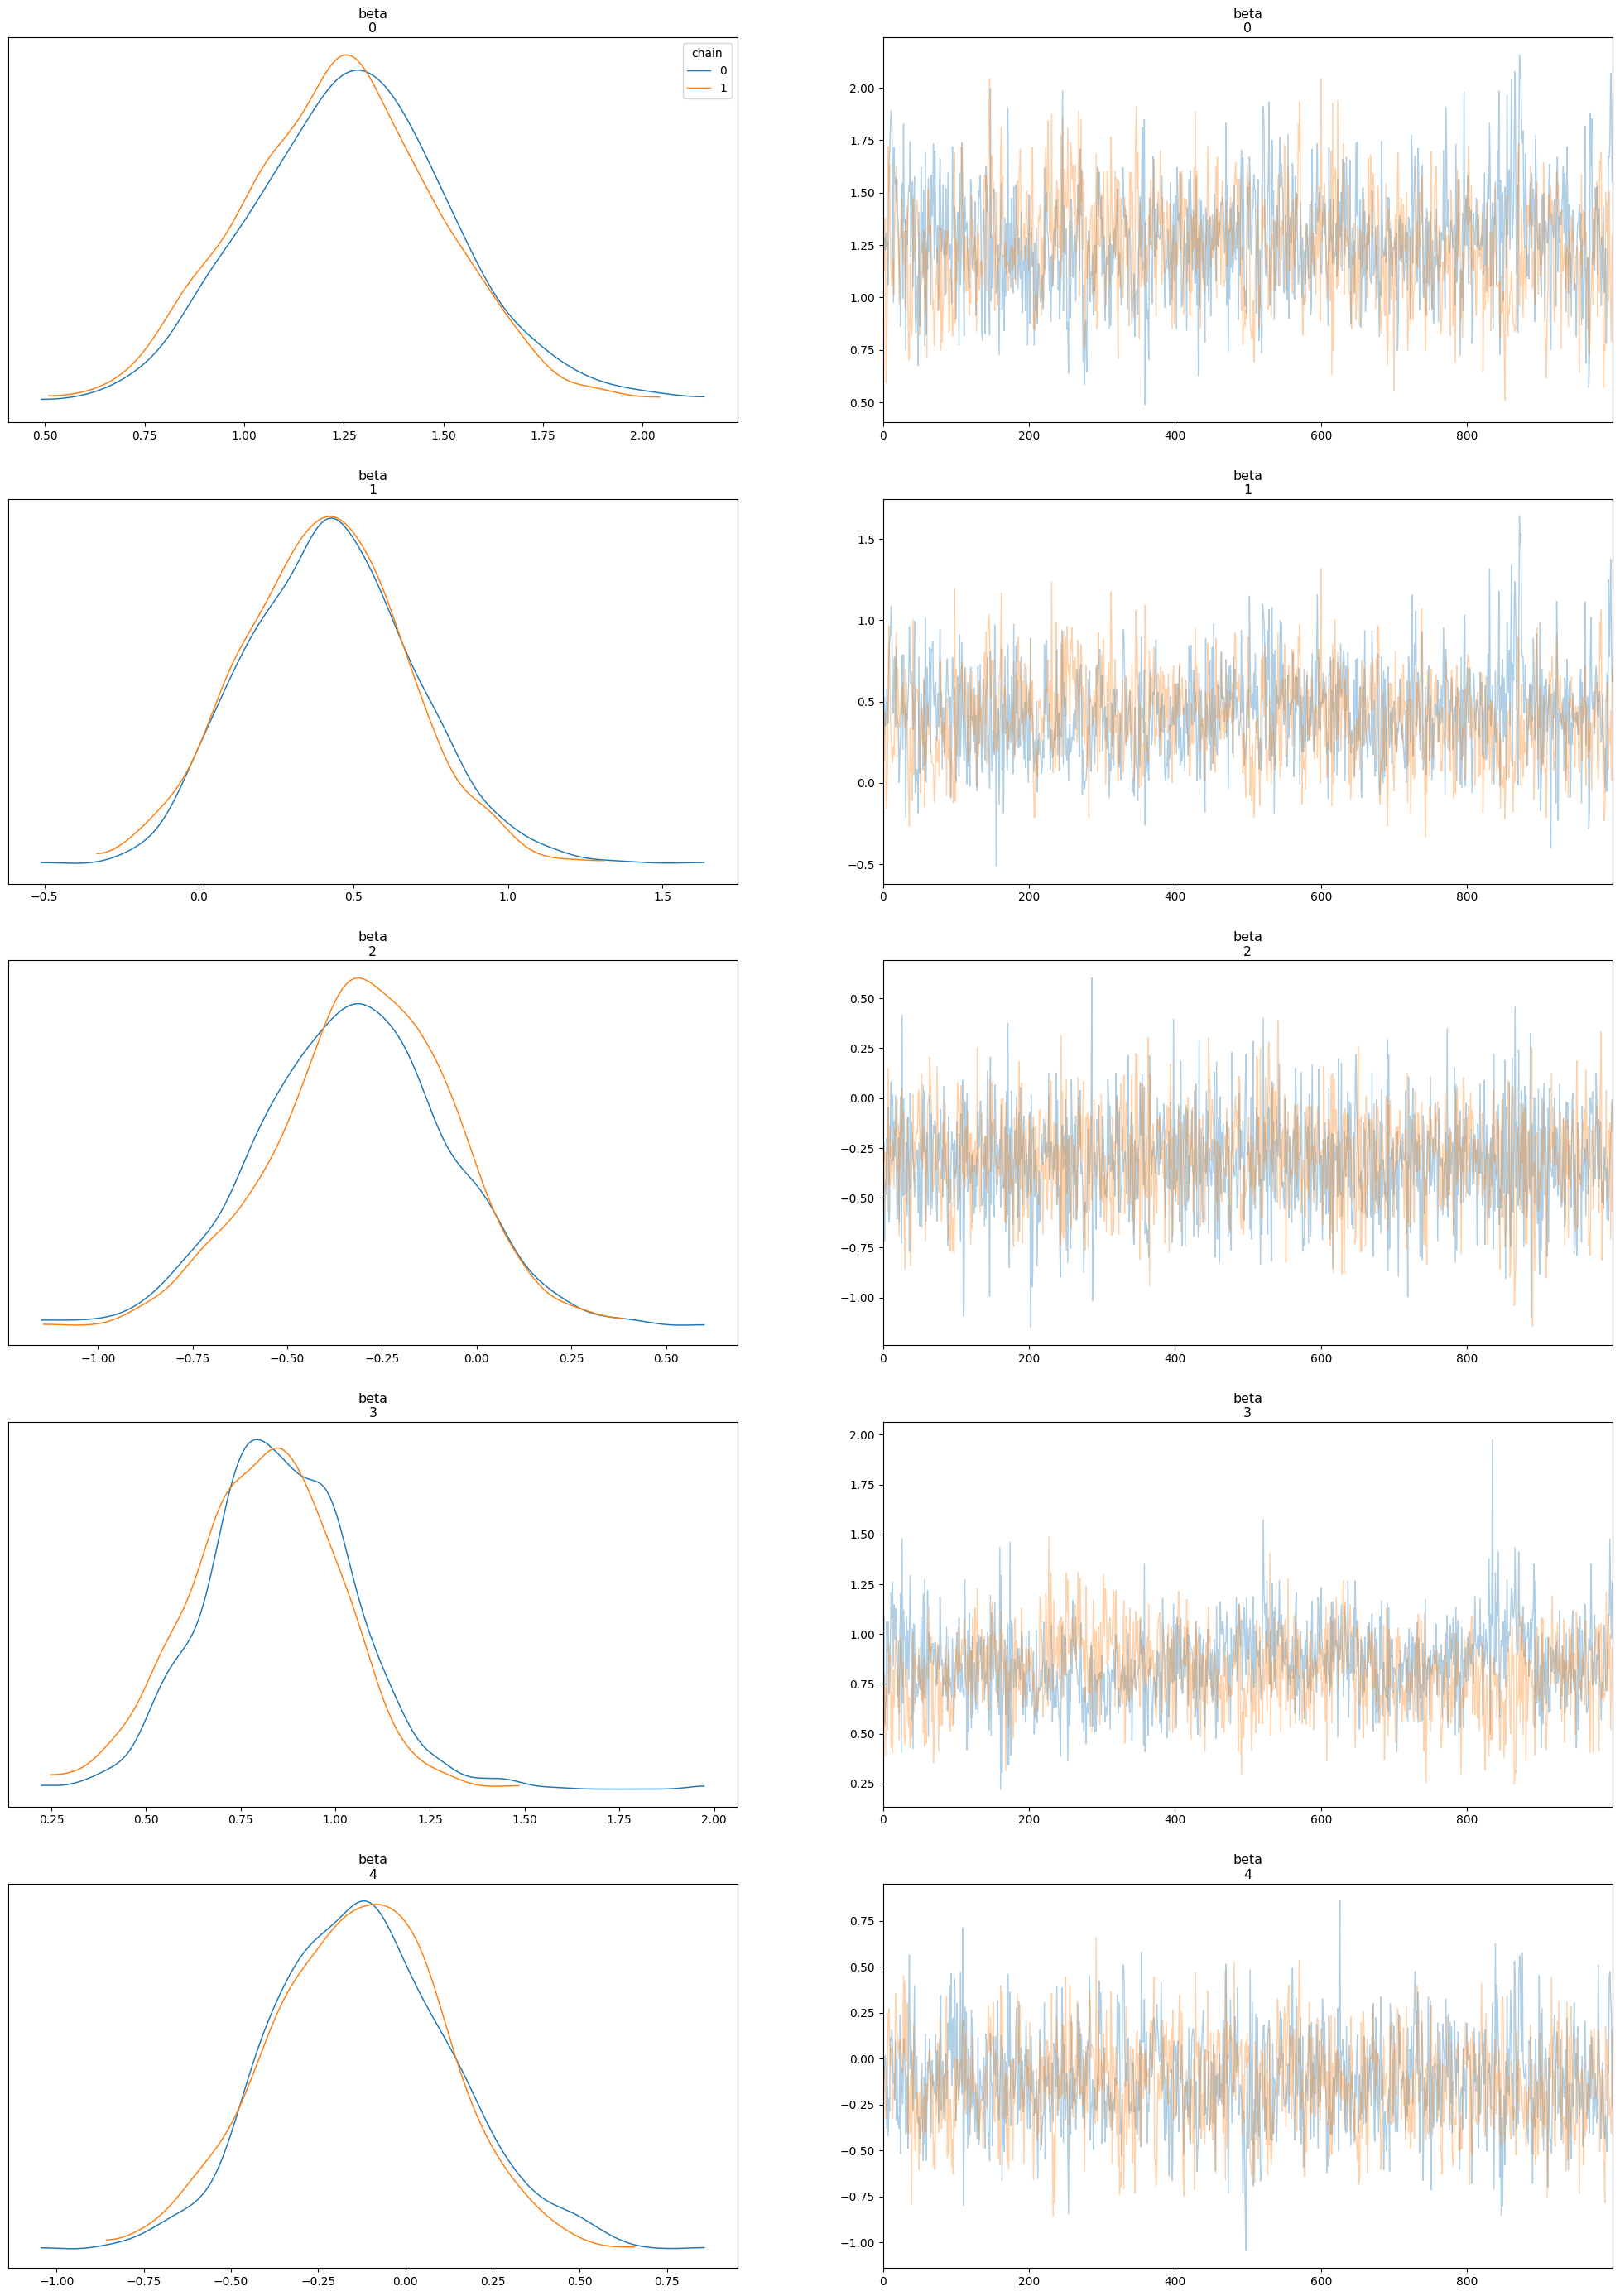

In [96]:
az.plot_trace(az_fit, ["beta","lambda"], figsize=(20,8), legend=True)
az.plot_trace(az_fit, ["beta"], figsize=(25,35), legend=True, compact=False)

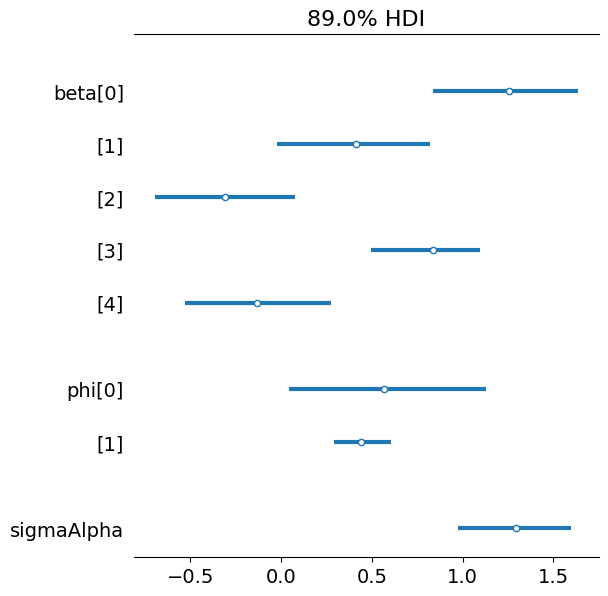

In [97]:
axes = az.plot_forest(az_fit,
                        kind='forestplot',
                        combined=True,
                        quartiles=False,
                        hdi_prob=0.89,
                        var_names=['beta','phi','sigmaAlpha']
                        )